# Notebook for midterm project - Tudor

### Importing the libraries and connection to database

In [4]:
#import libraries
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sqlite3

#import test_train_split
from sklearn.model_selection import train_test_split

#import StandardScaler()
from sklearn.preprocessing import StandardScaler

#import scikit learn RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

#import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

#import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

#import XGBoost
from xgboost import XGBRegressor

#import GridSearchCV
from sklearn.model_selection import GridSearchCV

#import log scaler
from sklearn.preprocessing import RobustScaler

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#import SVRegressor
from sklearn.svm import SVR

#import pickle
import pickle

#import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor


pd.set_option('display.max_columns', None)


## Data Exploration

### Table information

In [5]:
#pull the list of tables from the database
tables = pd.read_sql_query('SELECT * FROM information_schema.tables WHERE table_schema = \'public\'', conn)

In [6]:
tables

,table_catalog,table_schema,table_name,table_type,self_referencing_column_name,reference_generation,user_defined_type_catalog,user_defined_type_schema,user_defined_type_name,is_insertable_into,is_typed,commit_action
0,mid_term_project,public,flights_test,BASE TABLE,None,None,None,None,None,YES,NO,None
1,mid_term_project,public,flights,BASE TABLE,None,None,None,None,None,YES,NO,None
2,mid_term_project,public,passengers,BASE TABLE,None,None,None,None,None,YES,NO,None
3,mid_term_project,public,fuel_comsumption,BASE TABLE,None,None,None,None,None,YES,NO,None


### Columns

In [7]:
#get column names from the table
columns = pd.read_sql_query('SELECT * FROM information_schema.columns WHERE table_schema = \'public\'', conn)

In [8]:
#coloumns to csv
columns.to_csv('columns.csv')

### Data selection

In [9]:
#select <0.3% random rows from the flights table
flights_ran_subset = pd.read_sql_query('SELECT * FROM flights WHERE random() < 0.003', conn)
flights_ran_subset.to_csv('flights_ran_subset.csv')

### Some checks on the data

In [10]:
#how many rows are we working with
pd.read_sql_query('SELECT COUNT(*) FROM flights', conn)
#15927485 rows

#lets see how many rows we have in the flight_test table
pd.read_sql_query('SELECT COUNT(*) FROM flights_test', conn)
#660556 rows


#count the number of rows by origin city
pd.read_sql_query('SELECT origin_city_name, COUNT(*) FROM flights GROUP BY origin_city_name', conn).to_csv('origin_city_name.csv')
#all flights leave USA, the Ontario,CA had be going for a sec there
pd.read_sql_query('SELECT dest_city_name, COUNT(*) FROM flights GROUP BY dest_city_name', conn).to_csv('dest_city_name.csv')
#and land in USA

In [11]:
#count the number of rows bewtween fl_date 2018-12-01 and 2019-01-01 (inclusive?, need to check)
pd.read_sql_query("SELECT COUNT(*) FROM flights WHERE fl_date between '2018-12-01' and '2019-01-01'", conn)

,count
0,669008


In [12]:
#count the number of rows bewtween fl_date 2019-12-01 and 2020-01-01 (inclusive?, need to check)
pd.read_sql_query("SELECT COUNT(*) FROM flights WHERE fl_date between '2019-12-01' and '2020-01-01'", conn)

,count
0,679941


In [13]:
#lets see how many different flights are in the flight table
pd.read_sql_query("SELECT op_carrier_fl_num FROM flights WHERE fl_date between '2018-12-01' and '2018-12-31' GROUP BY op_carrier_fl_num", conn)

,op_carrier_fl_num
0,1
1,2
2,3
3,4
4,5
...,...
7012,9378
7013,9379
7014,9380
7015,9381


In [14]:
#lets see how many different flights we are working with in december 2018
pd.read_sql_query("SELECT op_carrier_fl_num FROM flights WHERE fl_date between '2018-12-01' and '2018-12-31' GROUP BY op_carrier_fl_num", conn)

,op_carrier_fl_num
0,1
1,2
2,3
3,4
4,5
...,...
7012,9378
7013,9379
7014,9380
7015,9381


In [15]:
#check number of rows with arr_delay > 0
pd.read_sql_query("SELECT COUNT(*) FROM flights WHERE arr_delay > 0", conn)

,count
0,5475609


In [16]:
#percent of rows with arr_delay > 0
5475609 / 15927485 * 100

34.378365448154554

## Feature Engineering

### airport_id based features

#### Rank of Percent of flights delayed

In [17]:
#count of flights with arr_delay > 0
delay = pd.read_sql_query("SELECT origin_airport_id, count(*) FROM flights WHERE dep_delay > 0 GROUP BY origin_airport_id", conn)

#total flights
total = pd.read_sql_query("SELECT origin_airport_id, count(*) FROM flights GROUP BY origin_airport_id", conn)

#merge df into one, then add a column with the percentage of delay
delay_percent = delay.merge(total, on='origin_airport_id')
delay_percent['delay_percent'] = delay_percent['count_x'] / delay_percent['count_y'] * 100

#create new feature table for origin with delay_percent number
airport_features = delay_percent[['origin_airport_id', 'delay_percent']]

#sort the table by delay_percent
airport_features = airport_features.sort_values(by='delay_percent', ascending=True)

#create a new column with the rank of the delay_percent
airport_features['Ranking'] = range(1, len(airport_features) + 1)

#create CSV file
airport_features.to_csv('airport_features.csv')

### Tail number features

#### Age of aircraft

In [18]:
#import csv with date built
aircraft = pd.read_csv('aircraftDatabase.csv', low_memory=False)

#leave only registration and built year
aircraft = aircraft[['registration', 'built']]

#rename registration to tail_num
aircraft = aircraft.rename(columns={'registration': 'tail_num'})

In [19]:
#clean aircraft table
print(aircraft.shape)
aircraft = aircraft.dropna()
print(aircraft.shape)
aircraft = aircraft.drop_duplicates()
print(aircraft.shape)

(460000, 2)
(244135, 2)
(244127, 2)


In [20]:
#make table of aircraft from flights table
tail_num_features = pd.read_sql_query("SELECT DISTINCT tail_num, op_unique_carrier FROM flights", conn)

#left join aircraft table to tail_num_features
tail_num_features = pd.merge(tail_num_features, aircraft, how='left', on='tail_num')

#drop na values based on tail_num_features.tail_num.isna() AKA no tail_num
tail_num_features = tail_num_features[~tail_num_features.tail_num.isna()]

#change built to first 4 digits to signify year
tail_num_features['built'] = tail_num_features['built'].str[:4]

In [21]:
#create new df with op_unique_carrier and built
carrier_built_avg = tail_num_features[['op_unique_carrier', 'built']]

#drop na's
carrier_built_avg = carrier_built_avg.dropna()

#change built to int
carrier_built_avg['built'] = carrier_built_avg['built'].astype(int)

#create new df with average built year for each op_unique_carrier
carrier_built_avg = carrier_built_avg.groupby('op_unique_carrier').agg({'built': 'mean'})
#round built to nearest year
carrier_built_avg['built'] = carrier_built_avg['built'].round()

#change back to str
carrier_built_avg['built'] = carrier_built_avg['built'].astype(str)

#take only first 4 digits
carrier_built_avg['built'] = carrier_built_avg['built'].str[:4]

In [22]:
#fill in na's from tail_num_features['built'] with carrier_built_avg['built']

#merge tail_num_features and carrier_built_avg
tail_num_features = tail_num_features.merge(carrier_built_avg, on='op_unique_carrier')

#create new build column
tail_num_features['build'] = tail_num_features['built_x'].where(tail_num_features['built_x'].notnull(), tail_num_features['built_y'])

#drop op_unique_carrier, built_x and built_y
tail_num_features = tail_num_features.drop(['op_unique_carrier', 'built_x', 'built_y'], axis=1)

#drop duplicates
tail_num_features = tail_num_features.drop_duplicates()

#create new column with age of aircraft
tail_num_features['age'] = 2020 - tail_num_features['build'].astype(int)

#remove aircraft that have duplicated ages
tail_num_features = tail_num_features.drop_duplicates(subset='tail_num', keep='last')

#export to csv
tail_num_features.to_csv('tail_num_features.csv')

### Flight Number features (grouped by op_carrier_fl_num AND rounded crs_dep_time)

#### Create a table of unique op_carrier_fl_num and rounded crs_dep_time to serve as a feature table

In [23]:
#make a function to clean up the rounded crs_dep_time
def clean_round(df):
    ### 
    # change the round column in a dataframe to the first 2 digits signifying the hour
    ###
    df['round'] = df['round'].astype(str)
    df['round'] = df['round'].str.zfill(6)
    df['round'] = df['round'].str[:2]
    #change 24 to 23
    df.loc[df['round'] == '24', 'round'] = '23'
    return df


In [24]:
#create a table for all flights not just delayed
flight_num_features = pd.read_sql_query("SELECT op_carrier_fl_num, round(crs_dep_time, -2) as round, AVG(carrier_delay + weather_delay + nas_delay + security_delay + late_aircraft_delay) as Avg_sum_of_delays, AVG(arr_delay) as avg_del_total, count(*) as total_flights FROM flights GROUP BY op_carrier_fl_num, round", conn)

#clean round
clean_round(flight_num_features)

#reindex the table based on op_carrier_fl_num AND round
flight_num_features = flight_num_features.set_index(['op_carrier_fl_num', 'round'])

#### 'avg_sum_of_delays', 'avg_del_total', 'total_flights','avg_del_if_delayed', 'times_delayed', 'percent_delayed'

In [167]:
#find average delay for each group of op_carrier_fl_num AND crs_dep_time_rounded
#filter in rows with arr_delay > 0
flight_num_sub_if_delayed = pd.read_sql_query("SELECT op_carrier_fl_num, round(crs_dep_time, -2) as round, AVG(arr_delay) as avg_del_if_delayed, count(arr_delay) as times_delayed FROM flights WHERE arr_delay > 0 GROUP BY op_carrier_fl_num, round", conn)

#clean round
clean_round(flight_num_sub_if_delayed)

#reindex the table based on op_carrier_fl_num AND round
flight_num_sub_if_delayed = flight_num_sub_if_delayed.set_index(['op_carrier_fl_num', 'round'])

#join flight_num_features and flight_num_sub_if_delayed
flight_num_features = pd.merge(flight_num_features, flight_num_sub_if_delayed, how='left', left_index=True, right_index=True)

#drop duplicate rows
flight_num_features = flight_num_features.drop_duplicates()

#fill in NA's with 0
flight_num_features = flight_num_features.fillna(0)

#change times_delayed to int
flight_num_features['times_delayed'] = flight_num_features['times_delayed'].astype(int)

#create new column with the percentage of flights that were delayed
flight_num_features['percent_delayed'] = (flight_num_features['times_delayed'] / flight_num_features['total_flights'] * 100).round(2)

#export to csv
flight_num_features.to_csv('flight_num_features.csv')

NameError: name 'clean_round' is not defined

### Carrier features ###

#### 'avg_delay', 'avg_carrier_delay', 'avg_delay_if_del', 'avg_carrier_delay_if_del', 'total_flights', 'delayed_flights', 'percent_delayed'

In [26]:
#create a table of unique op_unique_carrier from flights
carrier_features = pd.read_sql_query("SELECT op_unique_carrier, AVG(arr_delay) as avg_delay, AVG(carrier_delay) as avg_carrier_delay, count(*) as total_flights FROM flights GROUP BY op_unique_carrier", conn)

#reindex the table based on op_unique_carrier
carrier_features = carrier_features.set_index('op_unique_carrier')

#create a table for delayed flights
carrier_features_del = pd.read_sql_query("SELECT op_unique_carrier, AVG(arr_delay) as avg_delay_if_del, AVG(carrier_delay) as avg_carrier_delay_if_del, count(*) as delayed_flights FROM flights WHERE arr_delay > 0 GROUP BY op_unique_carrier", conn)

#reindex the table based on op_unique_carrier
carrier_features_del = carrier_features_del.set_index('op_unique_carrier')

#join carrier_features and carrier_features_del
carrier_features = pd.merge(carrier_features, carrier_features_del, how='left', left_index=True, right_index=True)

#create new column for percent of flights that were delayed
carrier_features['percent_delayed'] = (carrier_features['delayed_flights'] / carrier_features['total_flights'] * 100).round(2)

carrier_features.to_csv('carrier_features.csv')

### Weather features ###

#### Create new SQL database for weather

In [61]:
#make a local SQL database
conn2 = sqlite3.connect('weather.sqlite')

In [ ]:

#create a table in SQL database for weather data
conn2.execute("CREATE TABLE weather (fl_date DATE, round INTEGER, lat INTEGER, lon INTEGER, time_epoch REAL, time REAL, temp_c REAL, temp_f REAL, is_day REAL, condition REAL, wind_mph REAL, wind_kph REAL, wind_degree REAL, wind_dir REAL, pressure_mb REAL, pressure_in REAL, precip_mm REAL, precip_in REAL, humidity REAL, cloud REAL, feelslike_c REAL, feelslike_f REAL, windchill_c REAL, windchill_f REAL, heatindex_c REAL, heatindex_f REAL, dewpoint_c REAL, dewpoint_f REAL, will_it_rain REAL, chance_of_rain REAL, will_it_snow REAL, chance_of_snow REAL, vis_km REAL, vis_miles REAL, gust_mph REAL, gust_kph REAL, PRIMARY KEY (fl_date, round, lat, lon))")

#### Create functions for saving, converting and checking weather values

In [ ]:
#create a function to get historical weather data from API and save to SQL server
def get_weather_data(date, hour, lat, lon):
    #sends data to SQL server
    #set parameters
    #apikey = os.environ["WEATHER_API_KEY"]
    location = lat, lon
    params = {'q': location, 'key': api_key, 'hour': hour, 'dt' : date}
    #set response
    #response = requests.get('http://api.weatherapi.com/v1/history.json', params=params)
    #return response
    #data = response.json()
    data = json_response
    #parse response

    #if list index out of range error, move onto next
    time_forecast = data['forecast']['forecastday'][0]['hour'][0]
    temp = pd.DataFrame([time_forecast], columns=time_forecast.keys())
    temp['condition'] = data['forecast']['forecastday'][0]['hour'][0]['condition']['text']

    #create new df based on date, hour, city
    df_data = [[date, hour, lat, lon]]
    df = pd.DataFrame(data = df_data, columns=['fl_date', 'round', 'lat', 'lon'])
    
    #concatenate new df with response df d
    df = pd.concat([df, temp], axis=1)

    #send df to SQL database
    df.to_sql(name='weather', con=conn2, if_exists='append', index=False)


In [100]:
#load airports.dat.txt from https://openflights.org/data.html
airports_locations = pd.read_csv('airports.dat.txt', sep=',', header=None, names=['id', 'name', 'city', 'country', 'iata', 'icao', 'lat', 'lon', 'alt', 'tz_id', 'dst', 'tz_name', 'type', 'source'])

#keep only columnbs IATA code, lat, and lon
airports_locations = airports_locations[['iata', 'lat', 'lon']]

#remove duplicates
airports_locations = airports_locations.drop_duplicates()

#remove rows with missing values
airports_locations = airports_locations.dropna()

#round lat and lon to 3 decimal places
airports_locations['lat'] = airports_locations['lat'].round(3)
airports_locations['lon'] = airports_locations['lon'].round(3)

airports_locations.to_csv('airports_locations.csv', index=False)

## Model

### built dataframe and import features

#### import sampled flights for df_train

In [210]:
#bring in flights from subset of flights_sampled_1.csv
df_train = pd.read_csv('flights_train.csv')
#keep the columns based on flights_test features
df_train = df_train[['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier', 'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num', 'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name', 'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'crs_arr_time', 'dup', 'crs_elapsed_time', 'flights', 'distance','arr_delay']]
#drop unused columns mkt_unique_carrier, branded_code_share, mkt_carrier, mkt_carrier_fl_num, origin_city_name, dest_city_name, dup, flights, distance
df_train = df_train.drop(columns=['mkt_unique_carrier', 'branded_code_share', 'mkt_carrier', 'mkt_carrier_fl_num', 'origin_city_name', 'dest_city_name', 'dup', 'flights', 'distance'])

/home/tudor/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: DtypeWarning: Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


#### import airport_features

In [1]:
def get_airport_features(df):
    #load airport_features from CSV
    airport_features = pd.read_csv('airport_features.csv')
    #merge airport_features onto df
    df = pd.merge(df, airport_features[['origin_airport_id','Ranking']], how='left', on='origin_airport_id')
    #rename Ranking column to Origin_Airport
    df = df.rename(columns={'Ranking': 'Origin_Airport'})
    #drop origin_airport_id column
    df = df.drop(columns=['origin_airport_id'])
    #merge airport_features onto df - dest
    df = pd.merge(df, airport_features[['origin_airport_id','Ranking']], how='left', left_on='dest_airport_id', right_on='origin_airport_id')
    #rename Ranking column to Dest_Airport
    df = df.rename(columns={'Ranking': 'Dest_Airport'})
    #drop origin_airport_id column
    df = df.drop(columns=['origin_airport_id'])
    #drop dddest_airport_id column
    df = df.drop(columns=['dest_airport_id'])
    return df

#### import tain_num features

In [2]:
def get_tail_num_features(df):
    #import tail_num features
    tail_num_features = pd.read_csv('tail_num_features.csv')
    #merge tail_num_features into df
    df = pd.merge(df, tail_num_features[['tail_num','age']], how='left', on='tail_num')
    #rename age to age of aircraft
    df = df.rename(columns={'age': 'Age_of_Aircraft'})
    #fill in nan with mean of column
    df['Age_of_Aircraft'] = df['Age_of_Aircraft'].fillna(df['Age_of_Aircraft'].mean())
    #change age_of_aircraft to int
    df['Age_of_Aircraft'] = df['Age_of_Aircraft'].astype(int)
    return df

#### import carrier features

In [3]:
def get_carrier_features(df):
    #import carrier features
    carrier_features = pd.read_csv('carrier_features.csv')
    #merge carrier_features into df
    df = pd.merge(df, carrier_features, how='left', on='op_unique_carrier')
    #rename avg_delay to carrier_avg_delay
    df = df.rename(columns={'avg_delay': 'Carrier_Avg_Delay'})
    #rename avg_carrier_delay to carrier_avg_carrier_delay
    df = df.rename(columns={'avg_carrier_delay': 'Carrier_Avg_Carrier_Delay'})
    #rename total_flights to carrier_total_flights
    df = df.rename(columns={'total_flights': 'Carrier_Total_Flights'})
    #rename avg_delay_if_del to carrier_avg_delay_if_del
    df = df.rename(columns={'avg_delay_if_del': 'Carrier_Avg_Delay_If_Delayed'})
    #rename avg_carrier_delay_if_del to carrier_avg_carrier_delay_if_del
    df = df.rename(columns={'avg_carrier_delay_if_del': 'Carrier_Avg_Carrier_Delay_If_Delayed'})
    #rename delayed_flights to carrier_delayed_flights
    df = df.rename(columns={'delayed_flights': 'Carrier_Delayed_Flights'})
    #rename percent_delayed to carrier_percent_delayed
    df = df.rename(columns={'percent_delayed': 'Carrier_Percent_Delayed'})
    return df

#### import weather data

In [32]:
#given a dataframe and column name, add two columns to the dataframe with lat and long based on the column value
def add_lat_long(df, col):
    #load airport_locations dataframe
    airport_locations = pd.read_csv('airports_locations.csv')
    #merge the lat and long columns from airports_locations onto df based on the column value
    df = pd.merge(df, airport_locations, how='left', left_on=col, right_on='iata')
    #drop the iata column
    df = df.drop(columns=['iata'])
    return df


In [5]:
#create new column in df called 'round' based on the rounded value of crs_dep_time
def add_round(df):
    #round crs_dep_time to the nearest hundred
    df['round'] = df['crs_dep_time'].astype(int).round(-2)
    #change back to string format
    df['round'] = df['round'].astype(str)
    #add leading zeros to the beginning of the string
    df['round'] = df['round'].str.zfill(4)
    #keep left most 2 characters
    df['round'] = df['round'].str[:2]
    #change 24 to 24
    df.loc[df['round'] == '24', 'round'] = '23'  
    return df

In [25]:
#filter flights missing weather data in SQL database
def missing_weather_data(df):

    #create a df with just fl_date, round, lat, and lon values in df
    df = df[['fl_date', 'round', 'lat', 'lon']]
    #drop duplicates
    df = df.drop_duplicates()

    #open conn2
    conn2 = sqlite3.connect('weather.sqlite')
    #pull all keys from weather table
    SQL_weather_records = pd.read_sql_query("SELECT DISTINCT fl_date, round, lat, lon FROM weather", conn2)
    SQL_weather_records['marker'] = 1
    #sent df['round'] to int
    df['round'] = df['round'].astype(int)
    
    #merge SQL_weather_records onto df
    df = pd.merge(df, SQL_weather_records, how='left', left_on=['fl_date', 'round', 'lat', 'lon'], right_on=['fl_date', 'round', 'lat', 'lon'])

    #drop the rows with marker = 1
    df = df[df.marker != 1]

    df = df.drop_duplicates()
    #if df has no rows, return None
    if len(df) == 0:
        return None
    return df

In [26]:
#now lets bring them all together
#given a df request weather data if not already in SQL database\
def confirm_weather_data(df):
    #check if df has round column, if not, add_round(df)
    if 'round' not in df.columns:
        df = add_round(df)
        print('added round')
    #check if df has lat and lon columns, if not, add_lat_long(df, 'origin')
    if 'lat' not in df.columns:
        df = add_lat_long(df, 'origin')
    #check what records are missing in SQL database
    if missing_weather_data(df) is None:
        print('no missing weather data')
        return None
    else:
        df = missing_weather_data(df)
    #remove duplicates from df
    df = df.drop_duplicates()
    #for each record in df, get weather data from API and save to SQL database
    for index, row in df.iterrows():
        get_weather_data(row['fl_date'], row['round'], row['lat'], row['lon'])
    

In [92]:
#create a new function to get weather data for a given date, hour, lat, and lon from SQL database to a modified df
def get_weather_features(df):
    #open conn2
    conn2 = sqlite3.connect('weather.sqlite')
    #pull all keys from weather table
    SQL_weather_records = pd.read_sql_query("SELECT DISTINCT * FROM weather", conn2)
    if 'round' not in df.columns:
        df = add_round(df)
        print('added round')
    #check if df has lat and lon columns, if not, add_lat_long(df, 'origin')
    if 'lat' not in df.columns:
        df = add_lat_long(df, 'origin')
    #sent df['round'] to int
    df['round'] = df['round'].astype(int)
    #merge SQL_weather_records onto df
    df = pd.merge(df, SQL_weather_records, how='left', left_on=['fl_date', 'round', 'lat', 'lon'], right_on=['fl_date', 'round', 'lat', 'lon'])
    df = df.drop(columns=['time_epoch', 'time', 'temp_f', 'wind_mph', 'wind_degree', 'wind_dir', 'pressure_in', 'precip_in', 'feelslike_f', 'windchill_f', 'heatindex_f', 'dewpoint_f', 'vis_miles', 'gust_mph','condition','will_it_rain','chance_of_rain','will_it_snow','chance_of_snow','is_day', 'feelslike_c'])
    return df
    

#### import flight number features

In [9]:
def get_flight_num_features(df):
    #import from csv no index
    flight_num_features = pd.read_csv('flight_num_features.csv')
    #sort by total_flights
    flight_num_features = flight_num_features.sort_values(by=['total_flights'], ascending=False)
    #change round to int
    flight_num_features['round'] = flight_num_features['round'].astype(str)
    #remove duplicates
    flight_num_features = flight_num_features.drop_duplicates(subset=['op_carrier_fl_num','round'], keep='first')
    #create round column
    df  = add_round(df)
    #change df round to str
    df['round'] = df['round'].astype(int)
    df['round'] = df['round'].astype(str)
    #merge flight_number_features into df
    df = pd.merge(df, flight_num_features, how='left', on=['op_carrier_fl_num','round'])
    return df

#### import date of the week

In [10]:
def get_days_of_week_features(df):
    #create new called dt
    df['dt'] = pd.to_datetime(df['fl_date'])
    # New column - Day of week (0 - Monday)
    df['dayofweek'] = df['dt'].dt.dayofweek
    #hot encoding
    df = pd.get_dummies(df, columns=['dayofweek'])
    #drop dt column
    df = df.drop(columns=['dt'])
    return df

#### get_all_features

In [40]:
def get_all_features(df):
    #get airport features
    df = get_airport_features(df)
    #get tail_num_features
    df = get_tail_num_features(df)
    #get carrier features
    df = get_carrier_features(df)
    #get weather features
    df = get_weather_features(df)
    #get flight_num_features
    df = get_flight_num_features(df)
    #get days_of_week_features
    df = get_days_of_week_features(df)
    return df

#### Cleanup after features insertion

In [157]:
#create function for df cleaning
def df_clean(df):
    #remove Na's
    df = df.dropna()
    #remove rows with age of aircraft greater than 100
    df = df[df['Age_of_Aircraft'] <= 100]
    #remove rows with avg_del_total greater than 200
    df = df[df['avg_del_total'] <= 200]
    #remove rows with percent_delayed 0.95
    df = df[df['percent_delayed'] <= 95]
    #remove rows with arr_delay greater than 200
    df = df[df['arr_delay'] <= 200]
    #drop unused columns, op_unique_carrier, tail_num, op_carrier_fl_num, round, origin, dest
    df = df.drop(columns=['fl_date', 'op_unique_carrier','Carrier_Avg_Carrier_Delay_If_Delayed','tail_num', 'op_carrier_fl_num', 'origin', 'dest', 'round', 'lat', 'lon'])
    return df


#### Scaling ## removed for now

### Running model

In [143]:
def flight_data_from_csv_by_date(date1, date2):
    #load df from csv
    df = pd.read_csv('flights_train.csv')
    #keep the columns based on flights_test features
    df = df[['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier', 'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num', 'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name', 'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'crs_arr_time', 'dup', 'crs_elapsed_time', 'flights', 'distance','arr_delay']]
    #drop unused columns mkt_unique_carrier, branded_code_share, mkt_carrier, mkt_carrier_fl_num, origin_city_name, dest_city_name, dup, flights, distance
    df = df.drop(columns=['mkt_unique_carrier', 'branded_code_share', 'mkt_carrier', 'mkt_carrier_fl_num', 'origin_city_name', 'dest_city_name', 'dup', 'flights', 'distance'])
    #filter by date1 and date2
    df = df[(df['fl_date'] >= date1) & (df['fl_date'] <= date2)]
    return df

In [233]:
#function to scale the data
def scale_df(df_train, df_test):
    SSscaler = StandardScaler()
    to_scale = ['Age_of_Aircraft','Carrier_Avg_Delay', 'Carrier_Avg_Carrier_Delay', 'Carrier_Avg_Delay_If_Delayed','Carrier_Delayed_Flights', 'temp_c', 'pressure_mb', 'humidity', 'windchill_c', 'heatindex_c', 'dewpoint_c', 'avg_sum_of_delays', 'avg_del_total','avg_del_if_delayed', 'percent_delayed']
    df_train[to_scale] = SSscaler.fit_transform(df_train[to_scale])
    df_test[to_scale] = SSscaler.transform(df_test[to_scale])
    MMscaler = MinMaxScaler(feature_range=(-5,5))
    to_scale = ['crs_dep_time','crs_arr_time','Origin_Airport','Dest_Airport','Carrier_Total_Flights','Carrier_Percent_Delayed','cloud','vis_km']
    df_train[to_scale] = MMscaler.fit_transform(df_train[to_scale])
    df_test[to_scale] = MMscaler.transform(df_test[to_scale])
    #log transform
    to_scale = ['crs_elapsed_time','wind_kph','precip_mm','gust_kph','total_flights','times_delayed']
    df_train[to_scale] = np.log1p(df_train[to_scale])
    df_test[to_scale] = np.log1p(df_test[to_scale])
    return df_train, df_test


In [ ]:
def rename_columns(df):
    #rename columns
    df = df.rename(columns={'crs_dep_time':'Est Departure Time','crs_arr_time':'Est Arrival Time','crs_elapsed_time':'Est Elapsed Time','Carrier_Avg_Delay':'Carrier_Avg_Arr_Delay','Carrier_Avg_Delay_If_Delayed':'Carrier_Avg_Arr_Delay_of_Delayed_Flights','Carrier_Delayed_Flights':'Carrier_Total_Delayed_Flights','Carrier_Percent_Delayed':'Carrier_Percent_Flights_Delayed','temp_c':'WE_Celcius','wind_kph':'WE_Wind','pressure_mb':'WE_Preasure','precip_mm':'WE_Precipitation','humidity':'WE_Humidity','cloud':'WE_Cloud','windchill_c':'WE_Windchill','heatindex_c':'WE_Heat_Index','dewpoint_c':'WE_Dew_Point','vis_km':'WE_Visability','gust_kph':'WE_Gust','avg_sum_of_delays':'FN_Avg_Sum_of_Delays','avg_del_total':'FN_Avg_Arr_Delay','total_flights':'FN_Total_Flights','avg_del_if_delayed':'FN_Avg_Arr_Delay_of_Delays','times_delayed':'FN_Times_delayed','percent_delayed':'FN_percent_delayed','dayofweek_0':'Monday','dayofweek_1':'Tuesday','dayofweek_2':'Wednesday','dayofweek_3':'Thursday','dayofweek_4':'Friday','dayofweek_5':'Saturday','dayofweek_6':'Sunday'})
    return df

In [ ]:
df_train = get_all_features(df_train)
df_train = df_clean(df_train)

added round


In [198]:
#create df for all data
df_train = flight_data_from_csv_by_date('2018-01-01', '2018-12-31')
print(df_train.shape)
df_train = get_all_features(df_train)
df_train = df_clean(df_train)

<ipython-input-198-190b71872580>:2: DtypeWarning: Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.
  df_train = flight_data_from_csv_by_date('2018-01-01', '2019-12-31')


(117000, 12)
added round


In [221]:
#create df jan 2018
df_jan2018 = flight_data_from_csv_by_date('2018-01-01', '2018-01-31')
print(df_jan2018.shape)
df_jan2018 = get_all_features(df_jan2018)
df_jan2018 = df_clean(df_jan2018)

<ipython-input-221-bcf3eed74a22>:2: DtypeWarning: Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.
  df_jan2018 = flight_data_from_csv_by_date('2018-01-01', '2018-01-31')


(17000, 12)
added round


In [234]:
#create df for training data
df_dec2018 = flight_data_from_csv_by_date('2018-01-01', '2018-12-31')
print(df_dec2018.shape)
df_dec2018 = get_all_features(df_dec2018)
df_dec2018 = df_clean(df_dec2018)

<ipython-input-234-c9bef4f8cc54>:2: DtypeWarning: Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.
  df_dec2018 = flight_data_from_csv_by_date('2018-01-01', '2018-12-31')


(58138, 12)
added round


In [222]:
#create df for training 2019 jan model
df_jan2019 = flight_data_from_csv_by_date('2019-01-01', '2019-01-31')
print(df_jan2019.shape)
df_jan2019 = get_all_features(df_jan2019)
df_jan2019 = df_clean(df_jan2019)

<ipython-input-222-dfd9a89ba3c9>:2: DtypeWarning: Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.
  df_jan2019 = flight_data_from_csv_by_date('2019-01-01', '2019-01-31')


(16730, 12)
added round


In [240]:
#create df for training 2019 jan model
df_dec2019 = flight_data_from_csv_by_date('2019-12-01', '2019-12-31')
print(df_dec2019.shape)
df_dec2019 = get_all_features(df_dec2019)
df_dec2019 = df_clean(df_dec2019)

<ipython-input-240-a2718091d975>:2: DtypeWarning: Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.
  df_dec2019 = flight_data_from_csv_by_date('2019-12-01', '2019-12-31')


(42132, 12)
added round


In [191]:
df_train = rename_columns(df_train)

In [199]:
#create X and y for training
y = df_train['arr_delay']
X = df_train.drop(columns=['arr_delay'])

In [235]:
#create X_dec2018 and y_dec2018 for training
y_dec2018 = df_dec2018['arr_delay']
X_dec2018 = df_dec2018.drop(columns=['arr_delay'])

In [241]:
#create X_dec2019 and y_dec2019 for training
y_dec2019 = df_dec2019['arr_delay']
X_dec2019 = df_dec2019.drop(columns=['arr_delay'])

In [236]:
#create X_jan2018 and y_jan2018 for training
y_jan2018 = df_jan2018['arr_delay']
X_jan2018 = df_jan2018.drop(columns=['arr_delay'])

In [237]:
#create X_jan2019 and y_jan2019 for testing
y_jan2019 = df_jan2019['arr_delay']
X_jan2019 = df_jan2019.drop(columns=['arr_delay'])

In [200]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    'bootstrap': [True, False]
}

In [85]:
#hyperparameter tuning
#create a dictionary of parameters to tune
param_dist = {
    'n_estimators': [50],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    'bootstrap': [True]
}

#create a random search object
random_search = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions=param_dist, n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)

#fit the random search object to the training data
random_search.fit(X, y)

#print the best parameters
print(random_search.best_params_)

#print the best score
print(random_search.best_score_)

#print the best estimator
print(random_search.best_estimator_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


/home/tudor/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


KeyboardInterrupt: 

In [219]:
#create random forest model with best parameters
rf_best = RandomForestRegressor(bootstrap=True, criterion='squared_error', max_depth=10, max_features='auto', min_samples_leaf=20, min_samples_split=10, n_estimators=50)
#fit the model
rf_best.fit(X_jan2018, y_jan2018)
#predict on test data
y_pred = rf_best.predict(X_jan2019)
#print the mean absolute error
print(mean_absolute_error(y_jan2019, y_pred))
print(mean_squared_error(y_jan2019, y_pred))
#print the score
print(rf_best.score(X_jan2019, y_jan2019))

#create df of feature importances
feature_importances = pd.DataFrame(rf_best.feature_importances_, index=X_jan2018.columns, columns=['importance'])
#sort the df
feature_importances.sort_values('importance', ascending=False, inplace=True)
#plot the feature importances
feature_importances.plot.barh(figsize=(10, 10), title='Feature Importances of Random Forest')
#select the top 15 features
top_15_features = rf_best.feature_importances_[:15]
#create a list of the top 15 features
top_15_features_list = X.columns[:15]
#create a dataframe of the top 15 features
top_15_features_df = pd.DataFrame({'feature': top_15_features_list, 'importance': top_15_features})
#sort the dataframe by importance
top_15_features_df = top_15_features_df.sort_values(by='importance', ascending=False)
#plot the top 15 features
top_15_features_df.plot.barh(x='feature', y='importance', figsize=(10, 10), title='Top 15 Features of the Random Forest Model')

20.79810998733328
896.9301064308235
-0.019996187396683407
[0.02440385 0.03251095 0.04531757 0.03112621 0.03083142 0.01641039
 0.03183454 0.01626563 0.00994303 0.01452691 0.00795179 0.11780447
 0.00838628 0.0727574  0.03274078 0.00423305 0.02447144 0.03126314
 0.04316863 0.01162874 0.02425413 0.0126738  0.0388585  0.01357671
 0.16609045 0.01746093 0.01341847 0.02088418 0.02124639 0.03345072
 0.00490518 0.00461606 0.00097825 0.00183937 0.0042752  0.00889791
 0.0049975 ]


20.032321328717572
0.3295838549015664
0.0058250488786102395


<AxesSubplot:ylabel='feature'>

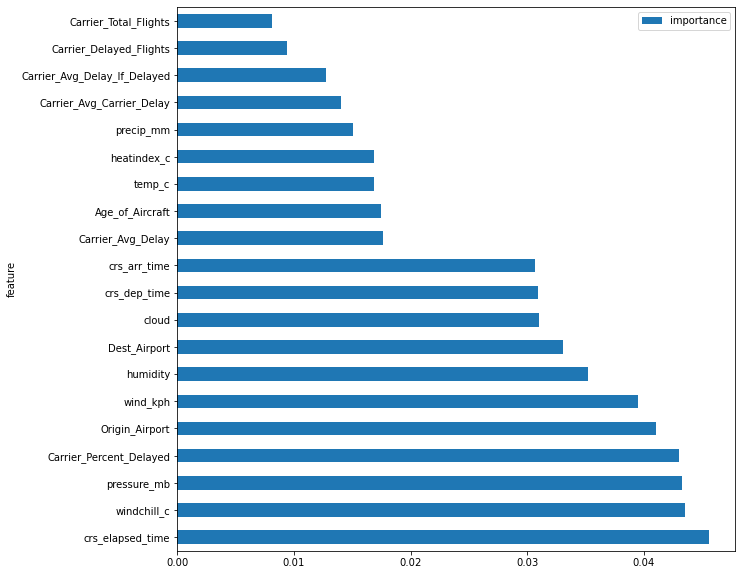

In [239]:
#create random forest model with best parameters for dec2018
rf_dec2018 = RandomForestRegressor(bootstrap=True, criterion='squared_error', max_depth=20, max_features='auto', min_samples_leaf=20, min_samples_split=10, n_estimators=250)
#fit the model
rf_dec2018.fit(X_dec2018, y_dec2018)
#predict on test data
y_pred_jan2019 = rf_dec2018.predict(X_jan2019)
#print the mean absolute error
print(mean_absolute_error(y_jan2019, y_pred_jan2019))
#print the score
print(rf_dec2018.score(X_dec2018, y_dec2018))
print(rf_dec2018.score(X_jan2019, y_jan2019))
#select the top 20 features
top_20_features = rf_dec2018.feature_importances_[:20]
#create a list of the top 20 features
top_20_features_list = list(X_dec2018.columns[:20])
#create a dataframe of the top 20 features
top_20_features_df = pd.DataFrame({'feature': top_20_features_list, 'importance': top_20_features})
#sort the dataframe by importance
top_20_features_df = top_20_features_df.sort_values(by='importance', ascending=False)
#plot the top 20 features
top_20_features_df.plot.barh(x='feature', y='importance', figsize=(10,10))

In [7]:
#load flight_test data from SQL
flight_test = pd.read_sql('SELECT * FROM flights_test', con=conn)

In [248]:
flight_test = get_all_features(flight_test)
flight_test = df_clean(flight_test)

In [2]:
flight_test

NameError: name 'flight_test' is not defined

20.032321328717572
0.3295838549015664
0.0058250488786102395


<AxesSubplot:ylabel='feature'>

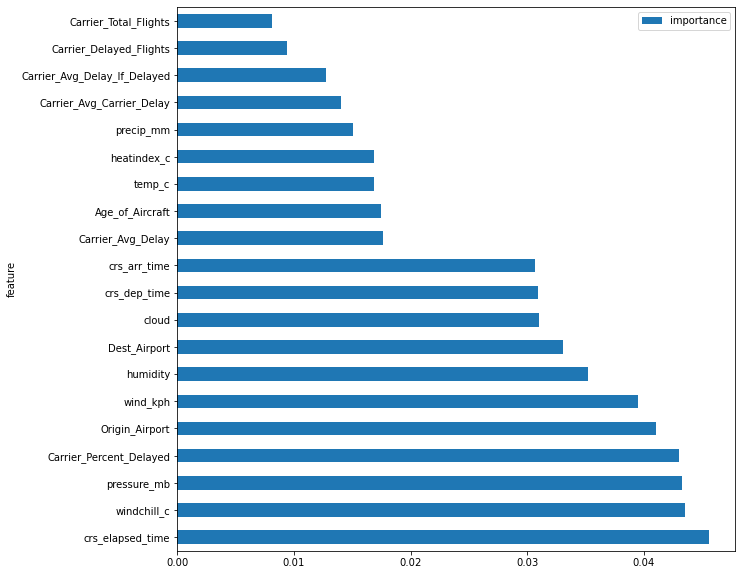

In [ ]:
#create random forest model with best parameters for dec2019
rf_dec2019 = RandomForestRegressor(bootstrap=True, criterion='squared_error', max_depth=20, max_features='auto', min_samples_leaf=20, min_samples_split=10, n_estimators=250)
#fit the model
rf_dec2019.fit(X_dec2019, y_dec2019)
#predict on flight_test data

In [227]:
X_jan2018, X_jan2019 = scale_df(X_jan2018, X_jan2019)

In [229]:
#rename the columns
X_jan2018 = rename_columns(X_jan2018)
X_jan2019 = rename_columns(X_jan2019)

In [ ]:
#SVM model
svm_model = SVR(kernel='rbf', C=1e3, gamma=0.1)
svm_model.fit(X_jan2018, y_jan2018)
y_pred_jan2019 = svm_model.predict(X_jan2019)
print(mean_absolute_error(y_jan2018, y_pred_jan2019))
print(svm_model.score(X_jan2018, y_jan2018))
print(svm_model.score(X_jan2019, y_jan2019))


[14:16:35] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


21.99724434393829
-0.11084171718676838


<AxesSubplot:title={'center':'Feature Importances of the XGBoost Model'}, ylabel='feature'>

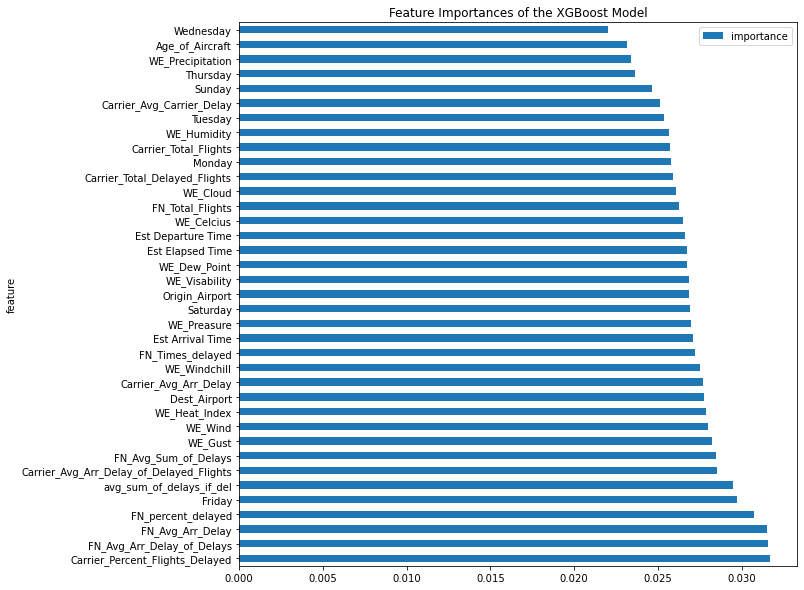

In [232]:
#create a XGBoost model
xgb_model = XGBRegressor(colsample_bytree=0.2, gamma=0.0, learning_rate=0.01, max_depth=5, min_child_weight=1.5, n_estimators=7200, reg_alpha=0.9, reg_lambda=0.6, subsample=0.2, silent=1, nthread=1)

#fit the model
xgb_model.fit(X_jan2018, y_jan2018)
#predict on test data
y_pred = xgb_model.predict(X_jan2019)
#print the mean absolute error
print(mean_absolute_error(y_jan2019, y_pred))
#print the score
print(xgb_model.score(X_jan2019, y_jan2019))
#create a dataframe of the feature importances
xgb_feature_importances = pd.DataFrame({'feature': X_jan2018.columns, 'importance': xgb_model.feature_importances_})
#sort the dataframe by importance
xgb_feature_importances = xgb_feature_importances.sort_values(by='importance', ascending=False)
#plot the feature importances
xgb_feature_importances.plot.barh(x='feature', y='importance', figsize=(10,10), title='Feature Importances of the XGBoost Model')


<AxesSubplot:title={'center':'Top 15 Features of the XGBoost Model'}, ylabel='feature'>

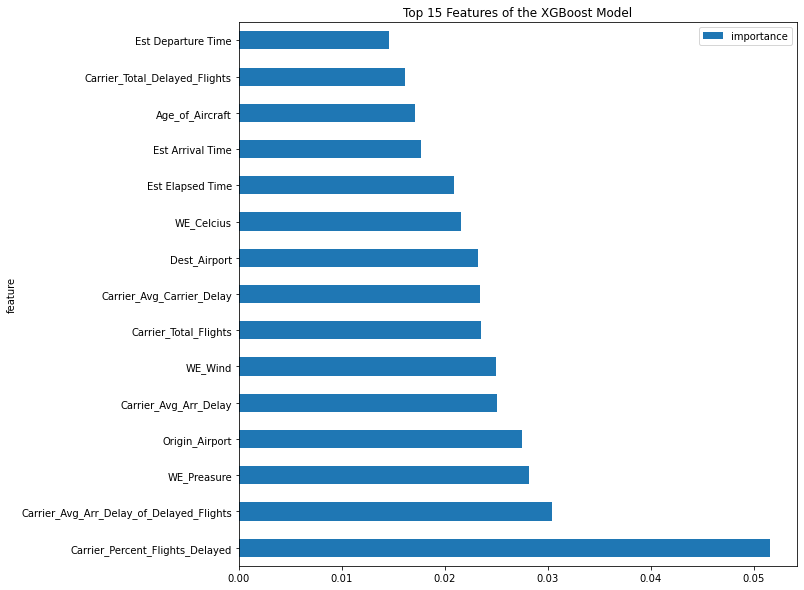

In [209]:
#look at the top 15 features
top_15_features = xgb_model.feature_importances_[:15]
#create a list of the top 15 features
top_15_features_list = X_train.columns[:15]
#create a dataframe of the top 15 features
top_15_features_df = pd.DataFrame({'feature': top_15_features_list, 'importance': top_15_features})
#sort the dataframe by importance
top_15_features_df = top_15_features_df.sort_values(by='importance', ascending=False)
#plot the top 15 features
top_15_features_df.plot.barh(x='feature', y='importance', figsize=(10,10), title='Top 15 Features of the XGBoost Model')

In [137]:
#scale 2018 and 2019 data
SSscaler = StandardScaler()
to_scale = ['Age_of_Aircraft','Carrier_Avg_Delay', 'Carrier_Avg_Carrier_Delay', 'Carrier_Avg_Delay_If_Delayed', 'Carrier_Delayed_Flights', 'temp_c', 'pressure_mb', 'humidity', 'windchill_c', 'heatindex_c', 'dewpoint_c', 'avg_sum_of_delays', 'avg_del_total', 'avg_sum_of_delays_if_del','avg_del_if_delayed', 'percent_delayed']
X_dec2018[to_scale] = SSscaler.fit_transform(X_dec2018[to_scale])
X_jan2019[to_scale] = SSscaler.transform(X_jan2019[to_scale])


In [138]:
#min max scaler the 2018 and 2019 data
MMscaler = MinMaxScaler(feature_range=(-5,5))
to_scale = ['crs_dep_time','crs_arr_time','Origin_Airport','Dest_Airport','Carrier_Total_Flights','Carrier_Percent_Delayed','cloud','vis_km']
X_dec2018[to_scale] = MMscaler.fit_transform(X_dec2018[to_scale])
X_jan2019[to_scale] = MMscaler.transform(X_jan2019[to_scale])

In [139]:
#log transform the 2018 and 2019 data
to_scale = ['crs_elapsed_time','wind_kph','precip_mm','gust_kph','total_flights','times_delayed']
X_dec2018[to_scale] = np.log1p(X_dec2018[to_scale])
X_jan2019[to_scale] = np.log1p(X_jan2019[to_scale])

In [140]:
#create a XGBoost model
xgb_model = XGBRegressor()
#fit the model
xgb_model.fit(X_dec2018, y_dec2018)
#predict on test data
y_pred_jan2019 = xgb_model.predict(X_jan2019)
#print the mean absolute error
print(mean_absolute_error(y_jan2019, y_pred_jan2019))
#print the score
print(xgb_model.score(X_jan2019, y_jan2019))

21.12930956654516
-0.07965822104014086


17.439410569188567
0.2869180512419657
-0.019706138830735576


<AxesSubplot:ylabel='feature'>

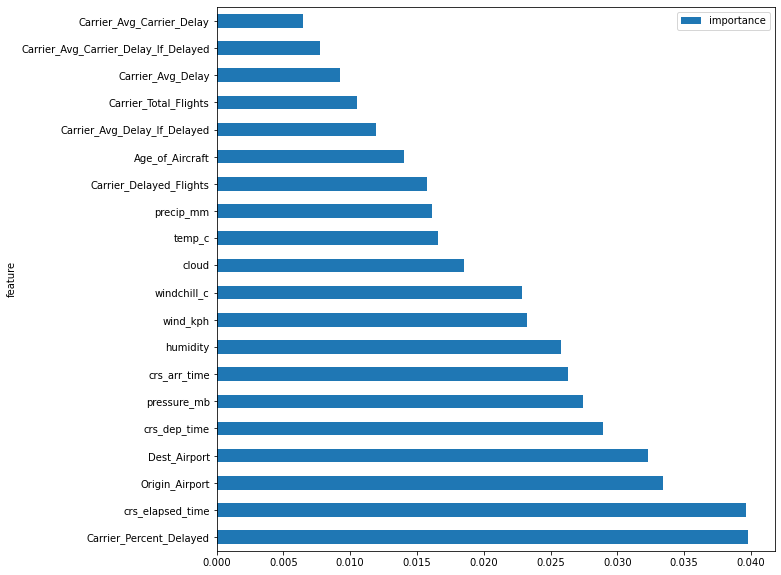

In [105]:
#create random forest model with best parameters for dec2018
rf_best_dec2018 = RandomForestRegressor(bootstrap=True, criterion='squared_error', max_depth=10, max_features='auto', min_samples_leaf=10, min_samples_split=10, n_estimators=100)
#fit the model
rf_best_dec2018.fit(X_dec2018, y_dec2018)
#predict on test data
y_pred_dec2018 = rf_best_dec2018.predict(X_dec2018)
#print the mean absolute error
print(mean_absolute_error(y_dec2018, y_pred_dec2018))
#print the score
print(rf_best_dec2018.score(X_dec2018, y_dec2018))
print(rf_best_dec2018.score(X_jan2019, y_jan2019))
#select the top 20 features
top_20_features = rf_best_dec2018.feature_importances_[:20]
#create a list of the top 20 features
top_20_features_list = list(X_dec2018.columns[:20])
#create a dataframe of the top 20 features
top_20_features_df = pd.DataFrame({'feature': top_20_features_list, 'importance': top_20_features})
#sort the dataframe by importance
top_20_features_df = top_20_features_df.sort_values(by='importance', ascending=False)
#plot the top 20 features
top_20_features_df.plot.barh(x='feature', y='importance', figsize=(10,10))


<AxesSubplot:ylabel='feature'>

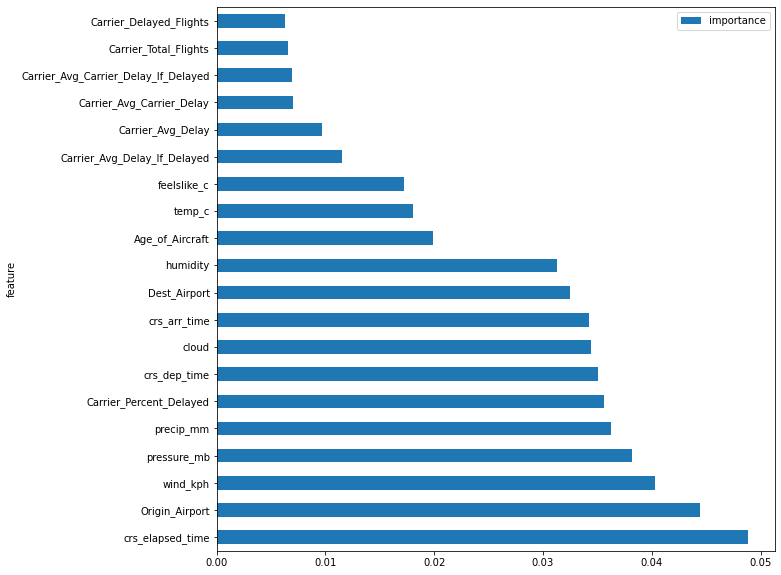

In [98]:
#select the top 20 features
top_20_features = rf_best.feature_importances_[:20]
#create a list of the top 20 features
top_20_features_list = list(X_train.columns[:20])
#create a dataframe of the top 20 features
top_20_features_df = pd.DataFrame({'feature': top_20_features_list, 'importance': top_20_features})
#sort the dataframe by importance
top_20_features_df = top_20_features_df.sort_values(by='importance', ascending=False)
#plot the top 20 features
top_20_features_df.plot.barh(x='feature', y='importance', figsize=(10,10))

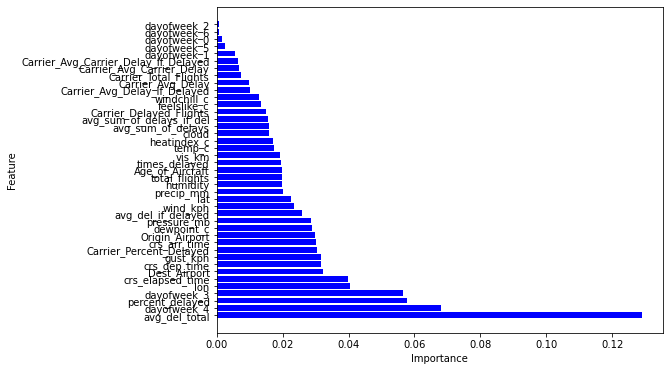

In [195]:
#select features
features = X.columns
#create feature importances
importances = model.feature_importances_
#create dataframe of features and importances
feature_importances = pd.DataFrame({'feature': features, 'importance': importances})
#sort by importance
feature_importances = feature_importances.sort_values(by=['importance'], ascending=False)
#plot
plt.figure(figsize=(8,6))
plt.barh(range(len(feature_importances)), feature_importances.importance, color='b', align='center')
plt.yticks(range(len(feature_importances)), feature_importances.feature)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [236]:
#create grid search for hyperparameters
param_grid = {'n_estimators': [100, 200, 300, 400, 500], 'max_depth': [10, 20, 30, 40, 50]}
#create grid search object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
#fit grid search
grid_search.fit(X_train, y_train)
#print best parameters
print(grid_search.best_params_)
#print best score
print(grid_search.best_score_)
#print best estimator
print(grid_search.best_estimator_)

In [1]:
#save model with pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(grid_search, f)

    

NameError: name 'pickle' is not defined

In [3]:
print(grid_search.best_estimator_)

NameError: name 'grid_search' is not defined

In [220]:
from sklearn.metrics import mean_squared_error

def compute_rmse(model, X, y):
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    return rmse

In [221]:
compute_rmse(model, X_test, y_test)

30.301397787921513